<a href="https://colab.research.google.com/github/ilayda-topcu/Bilgisayar_Programlama_Proje_Ilayda_TOPCU/blob/main/Bilgisayar_Programlama_Proje_Ilayda_TOPCU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from bs4 import BeautifulSoup
from datetime import datetime
from io_tools import outCsv

import requests
import json
import re
import time

URL = 'http://anitsayac.com/'

def main():
    date = datetime.strftime(datetime.now(), '%Y%m%d')
    cache_dict = get_cache('anitsayac_cache.json')

    res = requests.get(URL)
    soup = BeautifulSoup(res.content, features='lxml')
    feminisits = []
    for feminisit in soup.findAll('span', {'class':'xxy'}):
        a = feminisit.findChild('a')
        isim = a.getText()
        link = a.get('href')
        feminisits.append({'isim':isim, 'link':URL+link})
    with open('ref.json', 'w') as out:
        json.dump(feminisits, out, indent=2)

    feminisit_veri = []
    count = 0
    for f in feminisits:
        if f['link'] in cache_dict:
            veri = cache_dict[f['link']]
        else:
            print(f['isim'], 'not in cache')
            veri = get_data(f['link'])
            time.sleep(0.5)
        if veri:
            veri.update(f)
            feminisit_veri.append(veri)
            count += 1
            if count%50 == 0:
                print(count,'/',len(feminisits))
                with open('anitsayac_cache.json', 'w') as out:
                    json.dump(feminisit_veri, out, indent=2)

    with open('anitsayac_%s.json'%date, 'w') as out:
        json.dump(feminisit_veri, out, indent=2)

    keys = feminisit_veri[0].keys()
    outCsv(keys, feminisit_veri, 'anitsayac_%s.csv'%date)

def get_cache(filename):
    cache = json.load(open(filename))
    cache_dict = {}
    for c in cache:
        cache_dict[c['link']] = c
    return cache_dict

def get_data(url):
    res = requests.get(url)
    try:
        soup = BeautifulSoup(res.content, features='lxml')
    except Exception as e:
        print(url)
        print(e)
        return {}
    return parse_data(soup)

def parse_data(soup):
    body = soup.find('body')
    body_html = str(body)
    keys = [b.getText() for b in body.findAll('b')]
    q = '(\<b\>%s\<\/b\>)(.+?)\<'
    data = {}
    for key in keys:
        m = re.search(q%key, body_html)
        if not m:
            print(body_html)
            return {}
        data[key.strip()] = m.groups()[1].strip()
    # simdilik sadece tek kaynak URL aliyor
    if body.find('a'):
        data['Kaynak:'] = body.find('a').get('href')
    if body.find('img'):
        data['Gorsel:'] = body.find('img').get('src')
    return data

if __name__ == "__main__":
    main()

In [ ]:
pip install squarify

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import missingno as msno
import plotly.graph_objs as go
import plotly.express as px

from wordcloud import WordCloud
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [4]:
df = pd.read_csv('anitsayac_veriseti(2008-2024).csv')
df.head()

,Ad Soyad:,Maktülün yaşı:,İl/ilçe:,Tarih:,Neden öldürüldü:,Kim tarafından öldürüldü:,Korunma talebi:,Öldürülme şekli:,Failin durumu:,Kaynak:,Gorsel:,isim,link
0,Esma Şimşek,Reşit,Ankara,04/06/2024,Kıskançlık,Kocası,Yok,Kesici Alet,İntihar,https://www.hurriyet.com.tr/gundem/esini-ve-ko...,ii/1812024.jpg,Esma Şimşek,http://anitsayac.com/details.aspx?id=35789
1,Şule Özlem Ural,Reşit,Mersin,04/06/2024,Para,Tanıdığı Birisi,Yok,Boğularak,Tutuklu,https://www.hurriyet.com.tr/gundem/mersinde-va...,ii/1822024.jpg,Şule Özlem Ural,http://anitsayac.com/details.aspx?id=35790
2,Serap Doğan,Reşit,Ankara,01/06/2024,Reddedilme,Eskİ Sevgilisi,Var(Uzaklaştırma Kararı),Ateşli Silah,İntihar,https://www.hurriyet.com.tr/gundem/avcilarda-o...,ii/1782024.jpg,Serap Doğan,http://anitsayac.com/details.aspx?id=35786
3,Zeynep Kılıç,Reşit Değil,Bursa,01/06/2024,Eşinin tedbir kararı çıkartması üzerine,Babası,Yok,Kesici Alet,Tutuklu,https://www.hurriyet.com.tr/gundem/3-cocugunu-...,ii/1792024.jpg,Zeynep Kılıç,http://anitsayac.com/details.aspx?id=35787
4,Aslı Kılıç,Reşit Değil,Bursa,01/06/2024,Eşinin tedbir kararı çıkartması üzerine,Babası,Yok,Kesici Alet,Tutuklu,https://www.hurriyet.com.tr/gundem/3-cocugunu-...,ii/1802024.jpg,Aslı Kılıç,http://anitsayac.com/details.aspx?id=35788


In [6]:
# Verisetini oku
df = pd.read_csv('anitsayac_veriseti(2008-2024).csv')

# Başlıkları değiştirmek için bir sözlük tanımlayın
baslik_degisimleri = {
    'Tarih:': 'tarih',
    'Kim tarafından öldürüldü:': 'kim_tarafindan_olduruldu',
    'Korunma talebi:': 'korunma_talebi',
    'Neden öldürüldü:': 'neden_olduruldu',
    'Failin durumu:': 'failin_durumu',
    'Gorsel:': 'gorsel',
    'İsim': 'isim',
    'Maktülün yaşı:': 'maktulun_yasi',
    'Öldürülme şekli:': 'oldurulme_sekli',
    'Kaynak:': 'kaynak',
    'Ad Soyad:': 'ad_soyad',
    'İl/ilçe:': 'il_ilce',
}

# Sütun adlarını değiştir
df = df.rename(columns=baslik_degisimleri)

# Değiştirilen başlıklarla yeni bir CSV dosyası kaydet
yeni_veri_dosyasi = 'anitsayac_veriseti(2008-2024)_yeni_baslık.csv'
df.to_csv(yeni_veri_dosyasi, index=False)

print(f"Başlıklar değiştirildi ve yeni dosya '{yeni_veri_dosyasi}' olarak kaydedildi.")

Başlıklar değiştirildi ve yeni dosya 'anitsayac_veriseti(2008-2024)_yeni_baslık.csv' olarak kaydedildi.


In [13]:
# CSV dosyasını okuyun
df = pd.read_csv('anitsayac_veriseti(2008-2024)_yeni_baslık.csv')

# Tarih formatlarını normalize etme ve yılları çıkartma
def extract_year(date_str):
    for fmt in ('%d/%m/%Y', '%d.%m.%Y'):
        try:
            return pd.to_datetime(date_str, format=fmt).year
        except ValueError:
            pass
    return None

# Yeni sütunu oluşturma
df['yil'] = df['tarih'].apply(lambda x: extract_year(x))
df['yil'] = df['yil'].astype('Int64')  # Pandas'ın Int64 veri türünü kullanarak None değerleri desteklemek

# DataFrame'i yazdırma
print(df)

# Hatalı tarihleri bulma
invalid_dates = df[df['yil'].isnull()]

print("Geçersiz tarih formatına sahip veriler:")
print(invalid_dates)

# Yeni CSV dosyasını kaydetme
new_file_path = 'anitsayac_veriseti(2008-2024)_yil_eklendi.csv'
df.to_csv(new_file_path, index=False)

print(f"Yeni dosya '{new_file_path}' olarak kaydedildi.")

               ad_soyad maktulun_yasi   il_ilce       tarih  \
0           Esma Şimşek         Reşit    Ankara  04/06/2024   
1       Şule Özlem Ural         Reşit    Mersin  04/06/2024   
2           Serap Doğan         Reşit    Ankara  01/06/2024   
3          Zeynep Kılıç   Reşit Değil     Bursa  01/06/2024   
4            Aslı Kılıç   Reşit Değil     Bursa  01/06/2024   
...                 ...           ...       ...         ...   
4814   Gülceren Karakaş           NaN       NaN  10/01/2008   
4815  Hashatun Danışmaz           NaN       NaN  09/01/2008   
4816         Emel Çalış           NaN       NaN  07/01/2008   
4817        Gönül Özcan           NaN       NaN  06/01/2008   
4818       Figen İskeçe           NaN  İstanbul  01/01/2008   

                              neden_olduruldu kim_tarafindan_olduruldu  \
0                                  Kıskançlık                   Kocası   
1                                        Para          Tanıdığı Birisi   
2                    

In [14]:
df=pd.read_csv('anitsayac_veriseti(2008-2024)_yil_eklendi.csv')

In [15]:
df.head()

,ad_soyad,maktulun_yasi,il_ilce,tarih,neden_olduruldu,kim_tarafindan_olduruldu,korunma_talebi,oldurulme_sekli,failin_durumu,kaynak,gorsel,isim,link,yil
0,Esma Şimşek,Reşit,Ankara,04/06/2024,Kıskançlık,Kocası,Yok,Kesici Alet,İntihar,https://www.hurriyet.com.tr/gundem/esini-ve-ko...,ii/1812024.jpg,Esma Şimşek,http://anitsayac.com/details.aspx?id=35789,2024.0
1,Şule Özlem Ural,Reşit,Mersin,04/06/2024,Para,Tanıdığı Birisi,Yok,Boğularak,Tutuklu,https://www.hurriyet.com.tr/gundem/mersinde-va...,ii/1822024.jpg,Şule Özlem Ural,http://anitsayac.com/details.aspx?id=35790,2024.0
2,Serap Doğan,Reşit,Ankara,01/06/2024,Reddedilme,Eskİ Sevgilisi,Var(Uzaklaştırma Kararı),Ateşli Silah,İntihar,https://www.hurriyet.com.tr/gundem/avcilarda-o...,ii/1782024.jpg,Serap Doğan,http://anitsayac.com/details.aspx?id=35786,2024.0
3,Zeynep Kılıç,Reşit Değil,Bursa,01/06/2024,Eşinin tedbir kararı çıkartması üzerine,Babası,Yok,Kesici Alet,Tutuklu,https://www.hurriyet.com.tr/gundem/3-cocugunu-...,ii/1792024.jpg,Zeynep Kılıç,http://anitsayac.com/details.aspx?id=35787,2024.0
4,Aslı Kılıç,Reşit Değil,Bursa,01/06/2024,Eşinin tedbir kararı çıkartması üzerine,Babası,Yok,Kesici Alet,Tutuklu,https://www.hurriyet.com.tr/gundem/3-cocugunu-...,ii/1802024.jpg,Aslı Kılıç,http://anitsayac.com/details.aspx?id=35788,2024.0


In [16]:
df.columns

Index(['ad_soyad', 'maktulun_yasi', 'il_ilce', 'tarih', 'neden_olduruldu',
       'kim_tarafindan_olduruldu', 'korunma_talebi', 'oldurulme_sekli',
       'failin_durumu', 'kaynak', 'gorsel', 'isim', 'link', 'yil'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4819 entries, 0 to 4818
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ad_soyad                  4816 non-null   object
 1   maktulun_yasi             2838 non-null   object
 2   il_ilce                   3467 non-null   object
 3   tarih                     4819 non-null   object
 4   neden_olduruldu           4819 non-null   object
 5   kim_tarafindan_olduruldu  4819 non-null   object
 6   korunma_talebi            4809 non-null   object
 7   oldurulme_sekli           4816 non-null   object
 8   failin_durumu             3395 non-null   object
 9   kaynak                    4808 non-null   object
 10  gorsel                    4388 non-null   object
 11  isim                      4819 non-null   object
 12  link                      4819 non-null   object
 13  yil                       4782 non-null   Int64 
dtypes: Int64(1), object(13)


In [ ]:
df.drop(['tarih', 'isim', 'link', 'kaynak', 'gorsel'], axis=1).describe(include='all')

,ad_soyad,maktulun_yasi,il_ilce,neden_olduruldu,kim_tarafindan_olduruldu,korunma_talebi,oldurulme_sekli,failin_durumu,yil
count,4816,2838,3467,4819,4819,4809,4816,3395,4782.0
unique,4594,47,163,367,233,52,183,55,<NA>
top,İsmi Bilinmiyor,Reşit,İstanbul,Tespit Edilemeyen,Kocası,Yok,Ateşli Silah,Tutuklu,<NA>
freq,86,2566,546,1683,1570,4273,2168,1860,<NA>
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.623798
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.172905
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.0
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015.0
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018.0
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0


In [ ]:
df.describe()

,yil
count,4782.0
mean,2017.623798
std,4.172905
min,2008.0
25%,2015.0
50%,2018.0
75%,2021.0
max,2024.0


In [ ]:
df.isna().sum()

ad_soyad                       3
maktulun_yasi               1981
il_ilce                     1352
tarih                          0
neden_olduruldu                0
kim_tarafindan_olduruldu       0
korunma_talebi                10
oldurulme_sekli                3
failin_durumu               1424
kaynak                        11
gorsel                       431
isim                           0
link                           0
yil                           37
dtype: int64

In [ ]:
df['yil'].value_counts()

yil
2019    433
2021    432
2020    414
2023    410
2022    409
2018    404
2017    352
2015    292
2014    290
2016    289
2013    229
2010    192
2024    182
2012    142
2009    125
2011    120
2008     67
Name: count, dtype: Int64

In [ ]:
df['il_ilce'].value_counts()

il_ilce
İstanbul    546
İzmir       224
Antalya     169
Ankara      155
Adana       141
           ... 
Maltepe       1
Çiğli         1
Aralık        1
Saruhan       1
nevşehir      1
Name: count, Length: 163, dtype: int64

In [ ]:
df['il_ilce'].value_counts().describe()

count    163.000000
mean      21.269939
std       53.332993
min        1.000000
25%        1.000000
50%        5.000000
75%       18.000000
max      546.000000
Name: count, dtype: float64

In [ ]:
df['kim_tarafindan_olduruldu'].value_counts()

kim_tarafindan_olduruldu
Kocası                     1570
Tespit Edilemeyen           758
Sevgilisi                   400
Tanıdığı Birisi             287
Eski Kocası                 275
                           ... 
Kocasının kardeşi             1
Babasi                        1
Kocası, Tanıdığı Birisi       1
Eşi, Tanıdığı Birileri        1
Üvey baba                     1
Name: count, Length: 233, dtype: int64

In [ ]:
df['oldurulme_sekli'].value_counts()

oldurulme_sekli
Ateşli Silah             2168
Kesici Alet               997
Tespit Edilemeyen         424
Bıçaklama                 177
Darp                      148
                         ... 
Yanma, Darp                 1
Boğulma, Kesici Alet        1
Darp, Boğma, Yakma          1
Tecavüz, Boğulma            1
Atlama (Şüpheli Ölüm)       1
Name: count, Length: 183, dtype: int64

In [ ]:
df['maktulun_yasi'].value_counts()

maktulun_yasi
Reşit                2566
Reşit Değil           158
19                      7
24                      6
21                      6
Bilinmiyor              5
34                      5
32                      5
30                      5
45                      4
40                      4
Tespit Edilemeyen       4
31                      3
38                      3
35                      3
29                      3
36                      3
26                      3
15                      3
50                      2
20                      2
8                       2
Reşıt                   2
Belirtilmemiş           2
60                      2
52                      2
39                      2
42                      2
18                      2
27                      2
33                      2
28                      2
37                      2
25                      1
55                      1
57                      1
Reşi                    1
65                      

In [ ]:
df['neden_olduruldu'].value_counts()

neden_olduruldu
Tespit Edilemeyen        1683
Tartışma                 1212
Kıskançlık                218
Boşanma Talebi            214
Reddedilme                135
                         ... 
Eve Geç Gelmesi             1
Tespit Edileyen             1
Kız Kaçırma, Tartışma       1
Tartışma, Kaza              1
Madde bağımlılığı           1
Name: count, Length: 367, dtype: int64

In [ ]:
df['korunma_talebi'].value_counts()

korunma_talebi
Yok                                                              4273
Tespit Edilemeyen                                                 206
Var                                                               108
Bilinmiyor                                                         59
yok                                                                32
Gerçekleşmemiş                                                     29
Var (Uzaklaştırma Kararı)                                          18
Var Uzaklaştırma Kararı                                            13
Tespit EdilemeyenBilinmiyor                                        10
Korunma Talebi Var                                                  3
Var(Uzaklaştırma Kararı)                                            3
Var - Kadın Sığınma Evi                                             3
Korunma Altında                                                     3
Var - Sığınmaevi                                                    2
Şikay

In [ ]:
df['failin_durumu'].value_counts()

failin_durumu
Tutuklu                                                                                   1860
Tespit Edilemeyen                                                                          483
İntihar                                                                                    464
Soruşturma Sürüyor                                                                         199
Aranıyor                                                                                   179
İntihara Teşebbüs                                                                           43
Kaçak                                                                                       34
Bilinmiyor                                                                                  18
Tutuklandı                                                                                  12
Teslim oldu,sonucu bilinmiyor                                                                9
İntihar Etti                        

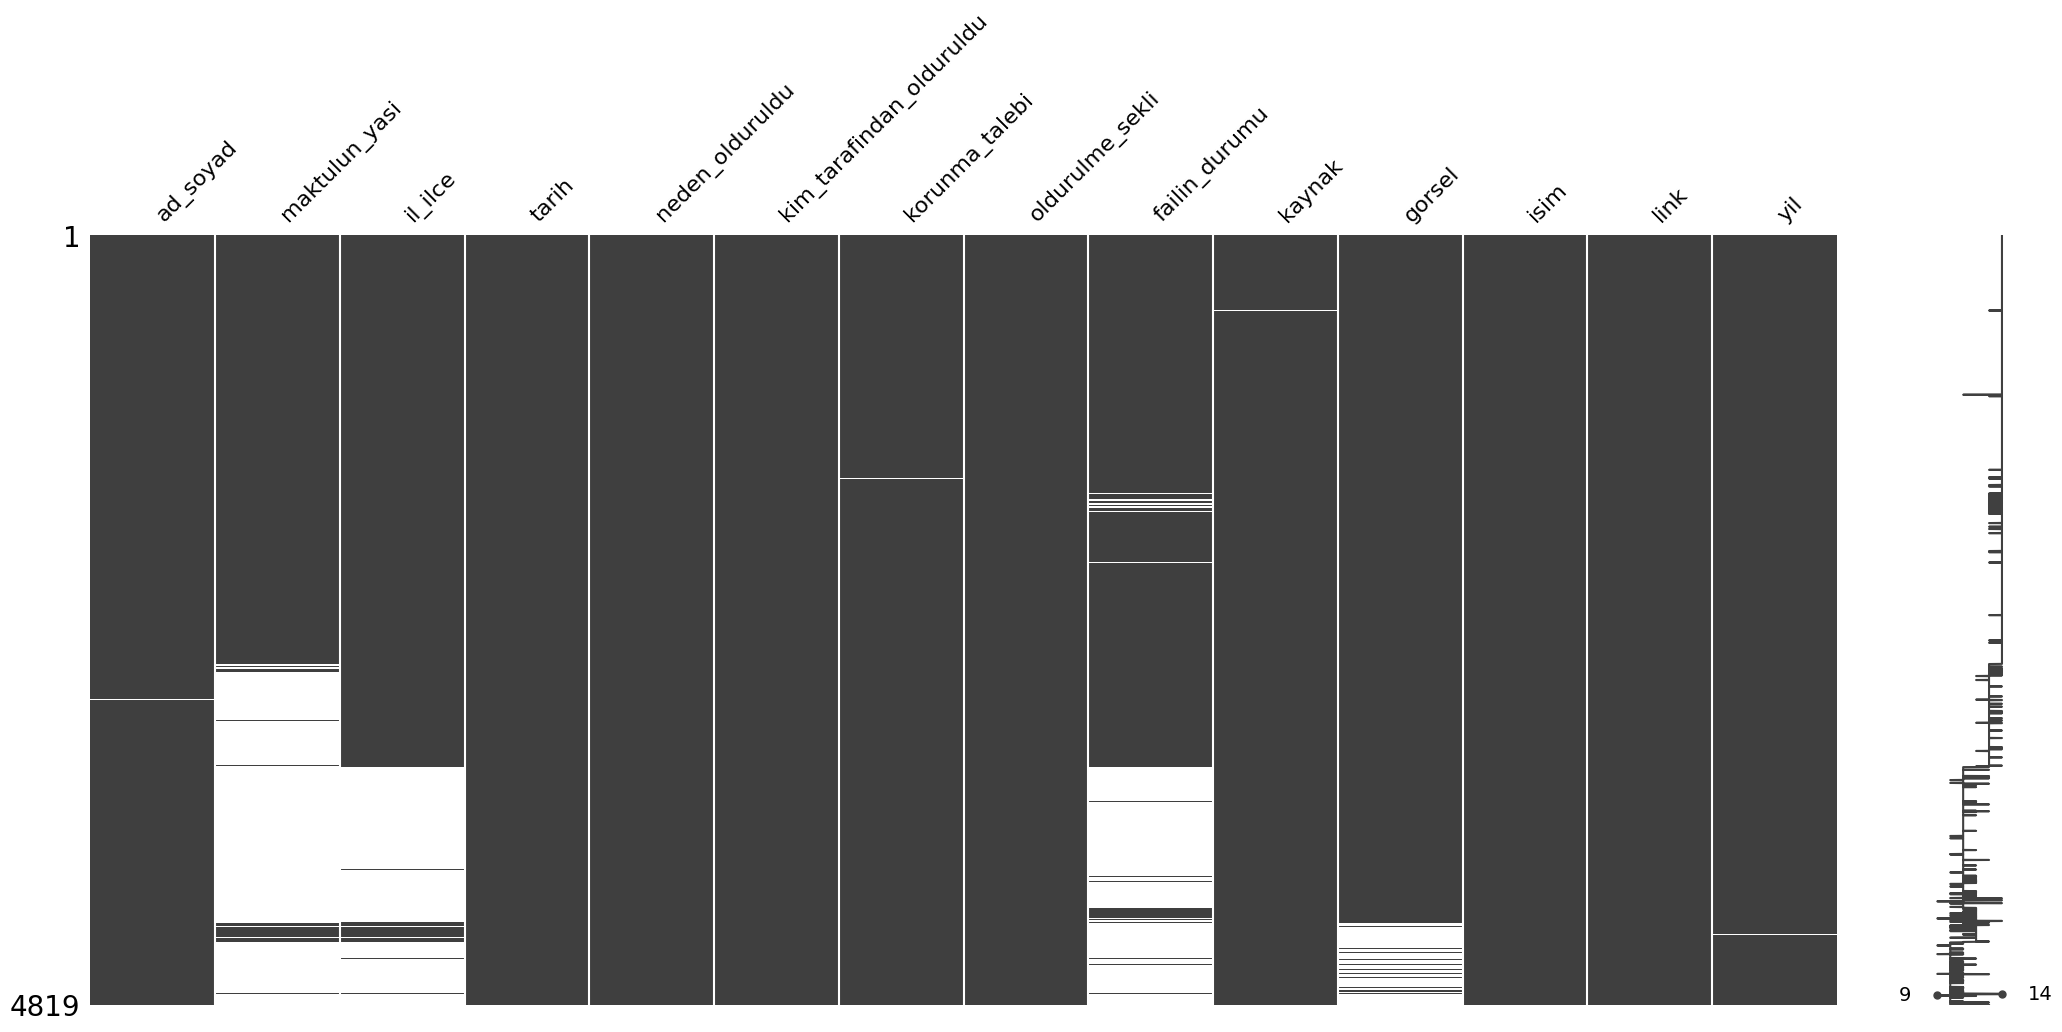

In [17]:
# Veri kümesini içeren bir DataFrame oluşturun
eksik_deger = pd.DataFrame(df)

# Eksik değerleri görselleştirin
msno.matrix(eksik_deger)

# Görselleştirmeyi görüntüleyin
plt.show()

<Axes: >

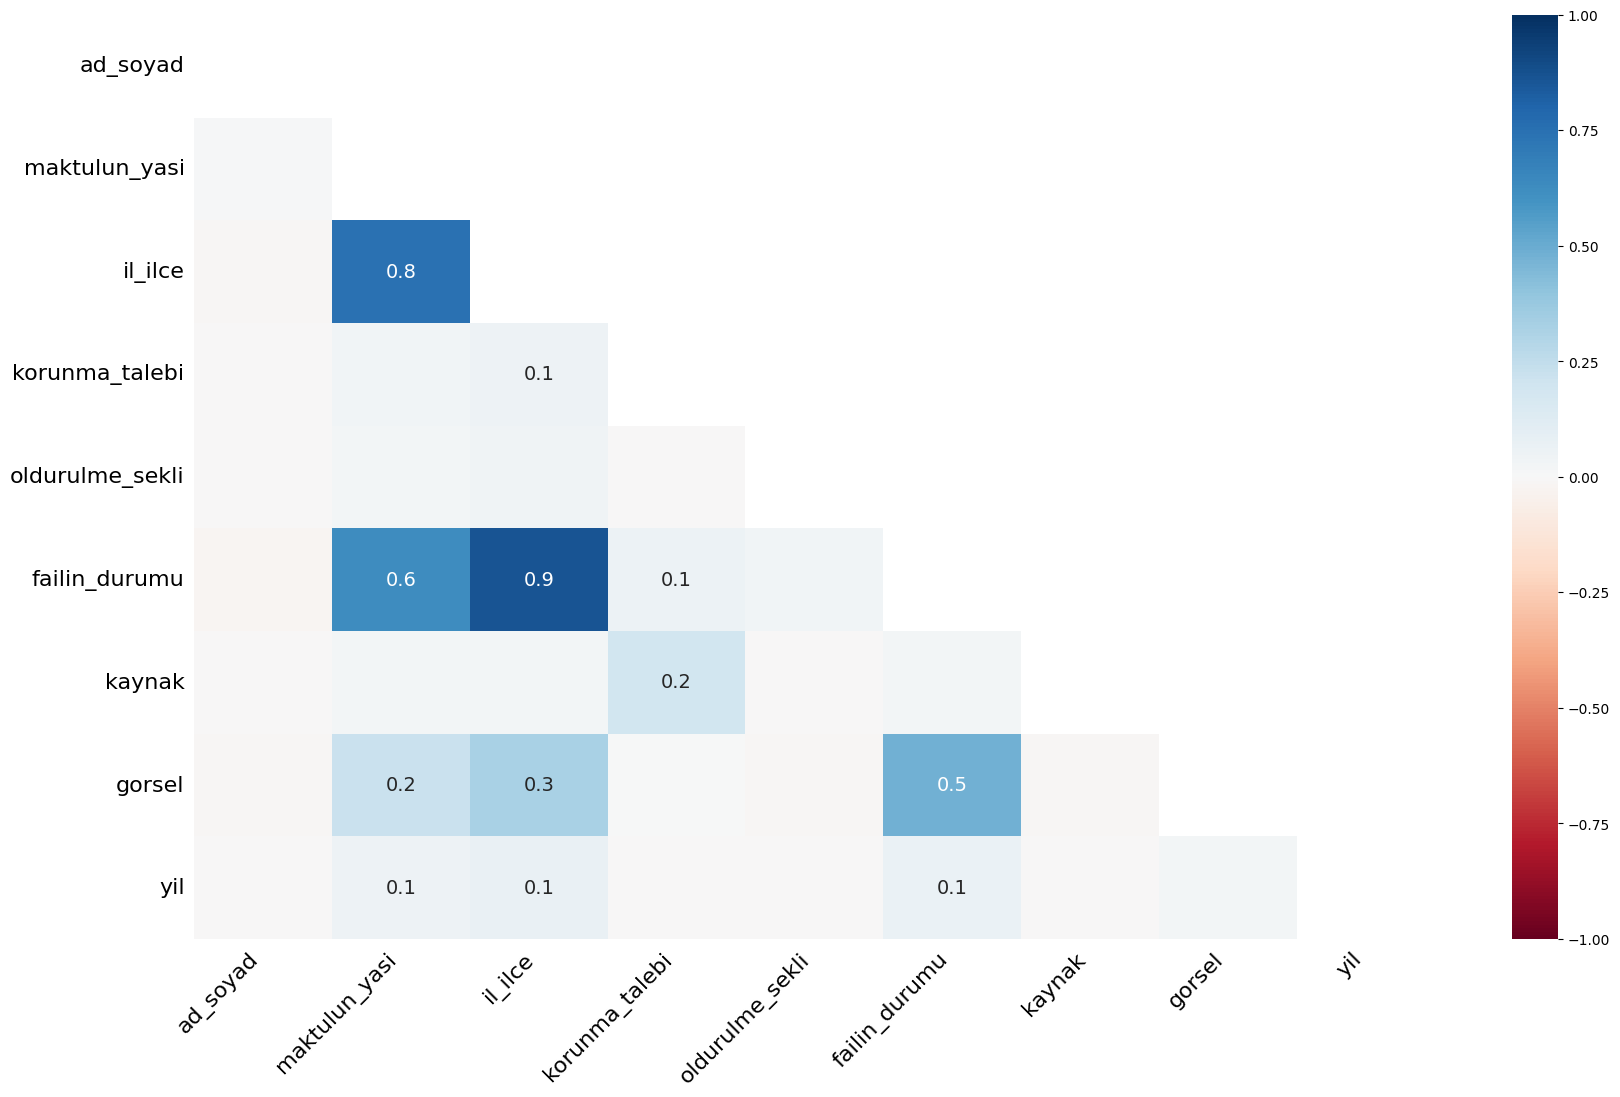

In [18]:
msno.heatmap(eksik_deger)

<Axes: >

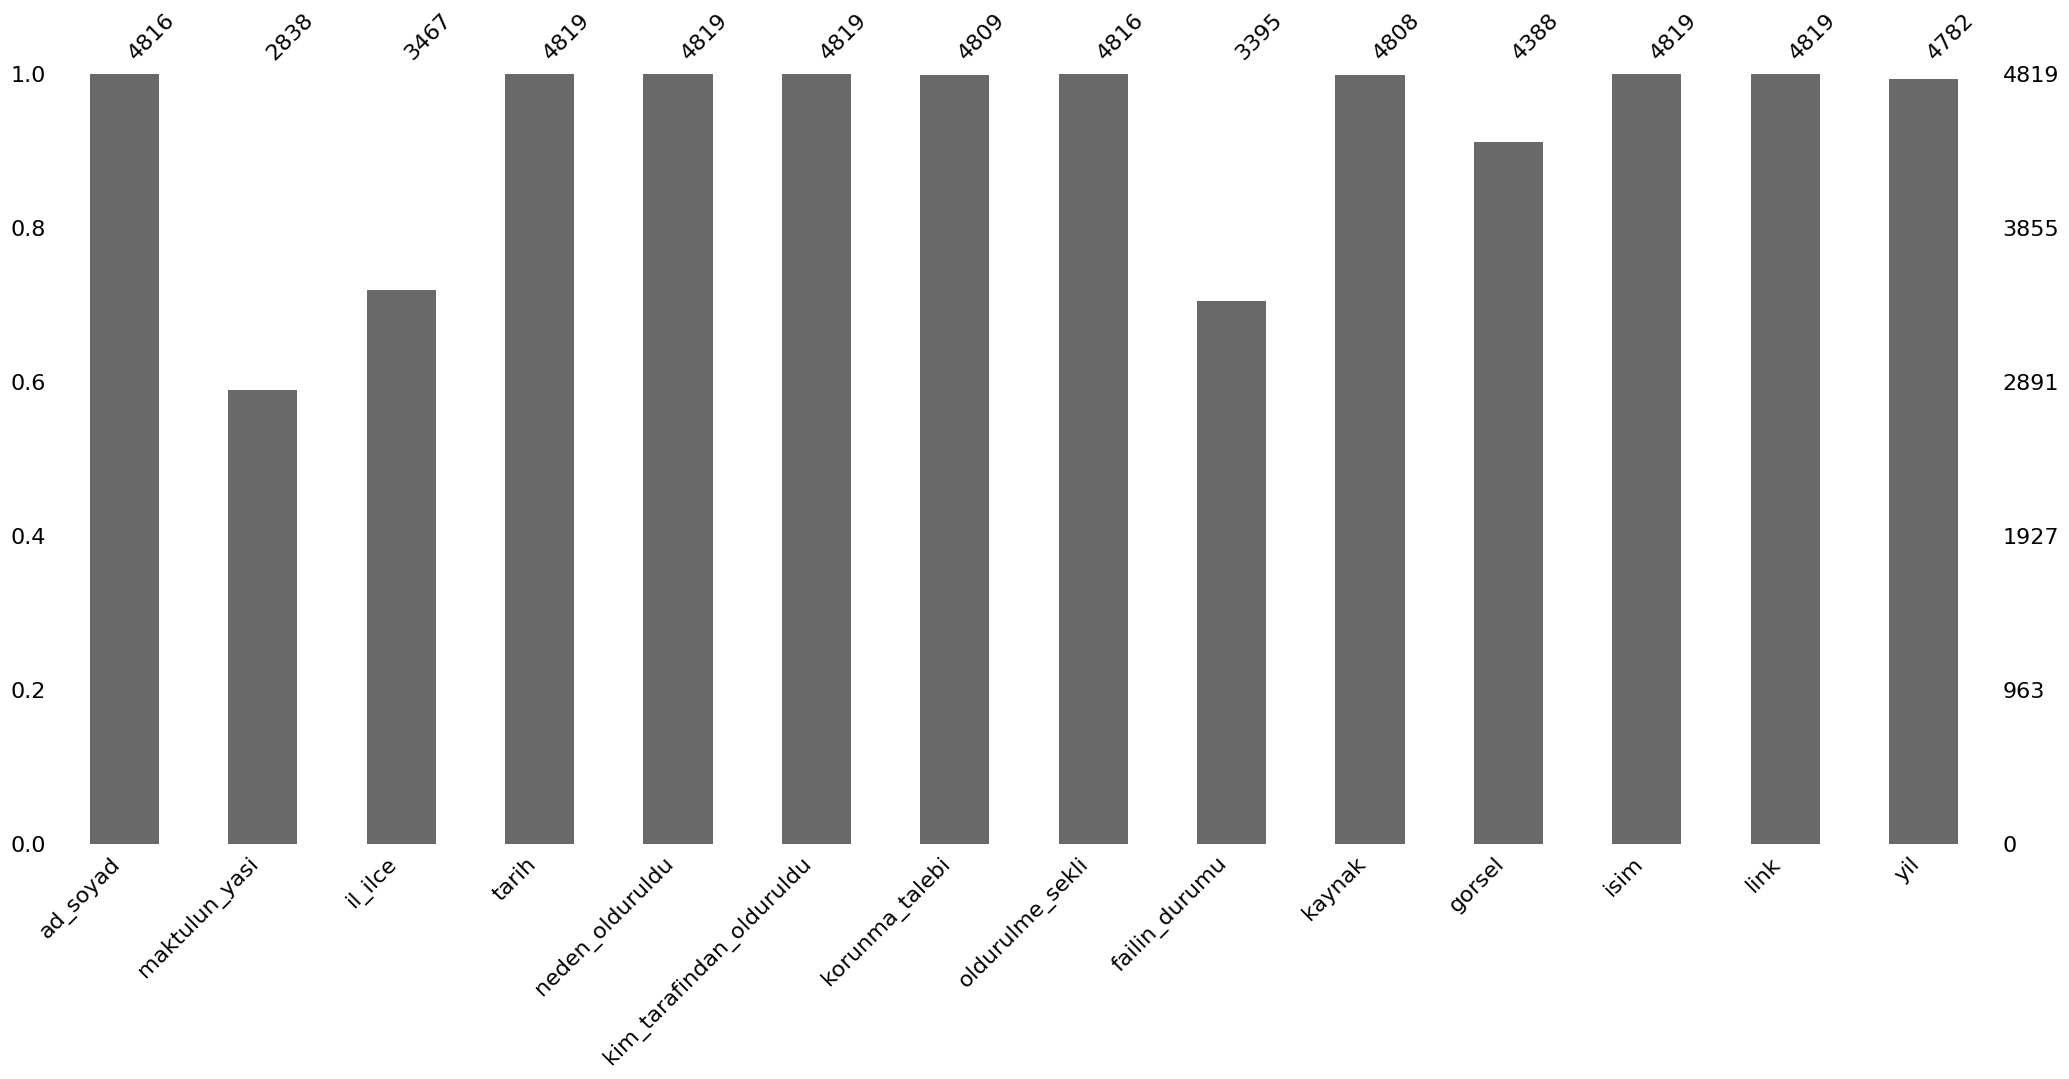

In [19]:
msno.bar(eksik_deger)

Boşlukları temizlemeden önce:
          ad_soyad maktulun_yasi il_ilce       tarih  \
0      Esma Şimşek         Reşit  Ankara  04/06/2024   
1  Şule Özlem Ural         Reşit  Mersin  04/06/2024   
2      Serap Doğan         Reşit  Ankara  01/06/2024   
3     Zeynep Kılıç   Reşit Değil   Bursa  01/06/2024   
4       Aslı Kılıç   Reşit Değil   Bursa  01/06/2024   

                           neden_olduruldu kim_tarafindan_olduruldu  \
0                               Kıskançlık                   Kocası   
1                                     Para          Tanıdığı Birisi   
2                               Reddedilme           Eskİ Sevgilisi   
3  Eşinin tedbir kararı çıkartması üzerine                   Babası   
4  Eşinin tedbir kararı çıkartması üzerine                   Babası   

             korunma_talebi oldurulme_sekli failin_durumu  \
0                       Yok     Kesici Alet       İntihar   
1                       Yok       Boğularak       Tutuklu   
2  Var(Uzaklaştırma Kar

<Axes: >

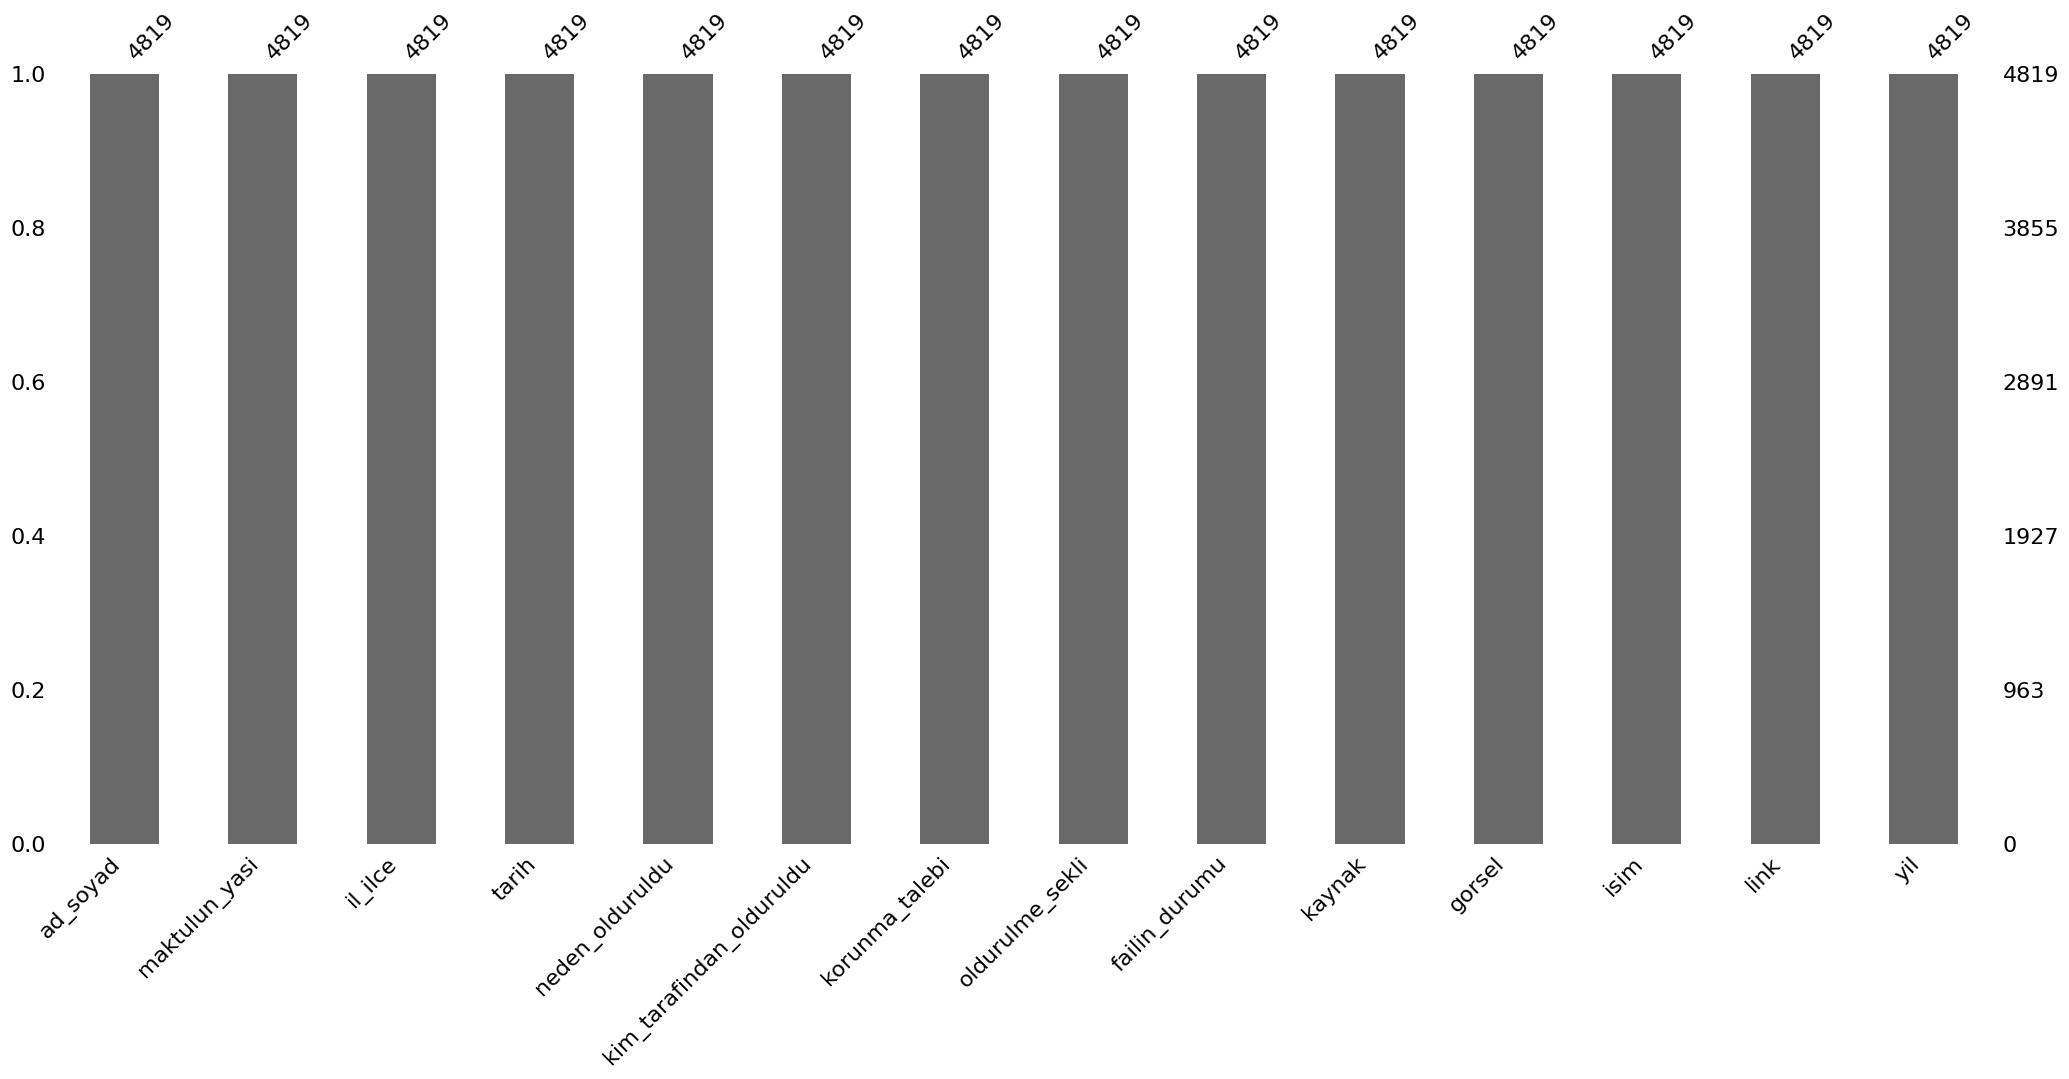

In [8]:
import pandas as pd
import missingno as msno

# Veri setini yükleyelim
veri_seti = pd.read_csv('anitsayac_veriseti(2008-2024)_yil_eklendi.csv')

# Boşlukları temizlemeden önce veri çerçevesini gösterelim
print("Boşlukları temizlemeden önce:")
print(veri_seti.head())

# Boşlukları temizleyelim
veri_seti = veri_seti.replace({"^\s*|\s*$":""}, regex=True)

# Eksik değerleri doldurabilir veya ele alabilirsiniz. Örneğin, eksik değerleri 0 ile doldurabilirsiniz
veri_seti = veri_seti.fillna(0)

# Veri çerçevesini df olarak yeniden adlandıralım
df = veri_seti

# Boşlukları temizledikten sonra veri çerçevesini gösterelim
print("\nBoşlukları temizledikten sonra:")
print(df.head())

# Eksik değerlerin sütun bazında sayısını çubuk grafik olarak görselleştirelim
msno.bar(df)

In [ ]:
date = df["yil"]
date

0       2024.0
1       2024.0
2       2024.0
3       2024.0
4       2024.0
         ...  
4814    2008.0
4815    2008.0
4816    2008.0
4817    2008.0
4818    2008.0
Name: yil, Length: 4819, dtype: float64

In [ ]:
df = df.replace({"^\s*|\s*$":""}, regex=True)

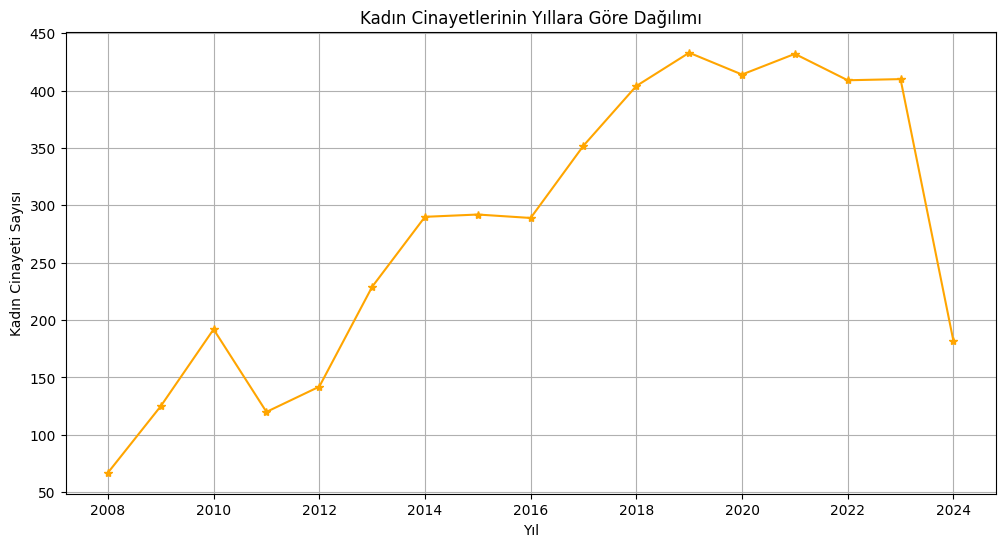

In [20]:
# Veriyi okuma
df = pd.read_csv('anitsayac_veriseti(2008-2024)_yil_eklendi.csv')

# Yıl sütunundaki boş değerleri düşürme
df_clean = df.dropna(subset=['yil'])

# Yıllara göre gruplama ve sayma
yearly_counts = df_clean['yil'].value_counts().sort_index()

# Veriyi görselleştirme
plt.figure(figsize=(12, 6))
plt.plot(yearly_counts.index, yearly_counts.values, marker='*', linestyle='-', color='orange')
plt.xlabel('Yıl')
plt.ylabel('Kadın Cinayeti Sayısı')
plt.title('Kadın Cinayetlerinin Yıllara Göre Dağılımı')
plt.grid(True)
plt.show()

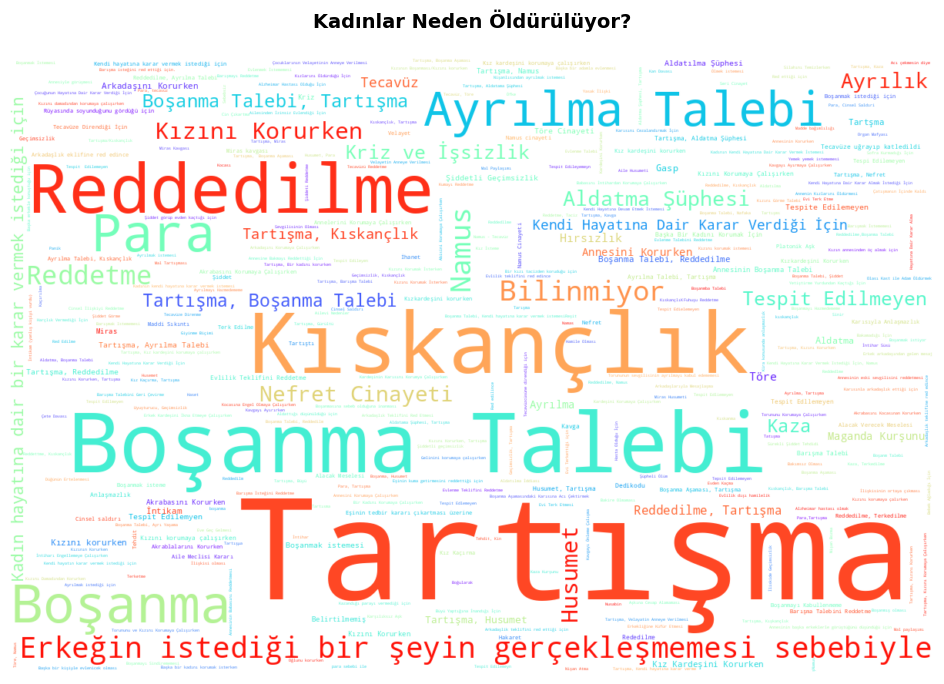

In [21]:
# 'neden_olduruldu' sütunundaki değerleri alalım ve boş değerleri kaldıralım
phrases = df['neden_olduruldu'].dropna().astype(str)

# 'tespit edilemeyen' kelimesini içeren satırları filtreleyelim
phrases = phrases[~phrases.str.contains('tespit edilemeyen', case=False)]

# Kelime gruplarının frekanslarını hesaplamak için bir sözlük oluşturun
phrase_counts = Counter(phrases)

# Kelime bulutunu oluşturun
wordcloud = WordCloud(
    background_color='white',
    width=1200,
    height=800,
    max_words=500,  # Gösterilecek maksimum kelime sayısı
    colormap='rainbow',
    normalize_plurals=False,  # Tekil ve çoğul kelimeleri aynı kelime olarak say
).generate_from_frequencies(phrase_counts)

# Kelime bulutunu görselleştirin
plt.figure(figsize=(50, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Başlığı daha fazla özelleştirin
plt.title(
    'Kadınlar Neden Öldürülüyor?\n',
    fontsize=14,
    color='black',
    fontweight='bold',
    fontstyle='normal'
)
plt.show()

In [ ]:
# Belirli şehirlerdeki verileri filtreleme
sehir = df[df['il_ilce'].isin(['Adana', 'Ankara', 'Antalya', 'Bursa', 'Eskişehir', 'İstanbul', 'İzmir'])]

# Nokta grafiği oluşturma
fig = px.scatter(sehir, x='yil', y='il_ilce', color='oldurulme_sekli')

# Grafik özelliklerini güncelleme
fig.update_layout(
    xaxis_title='Yıl',
    yaxis_title='Büyükşehir',
    legend_title='Öldürülme Şekli',
    title="\nBüyükşehirlerdeki Kadınların Öldürülme Şekilleri",

)
# Grafiği gösterme
fig.show()

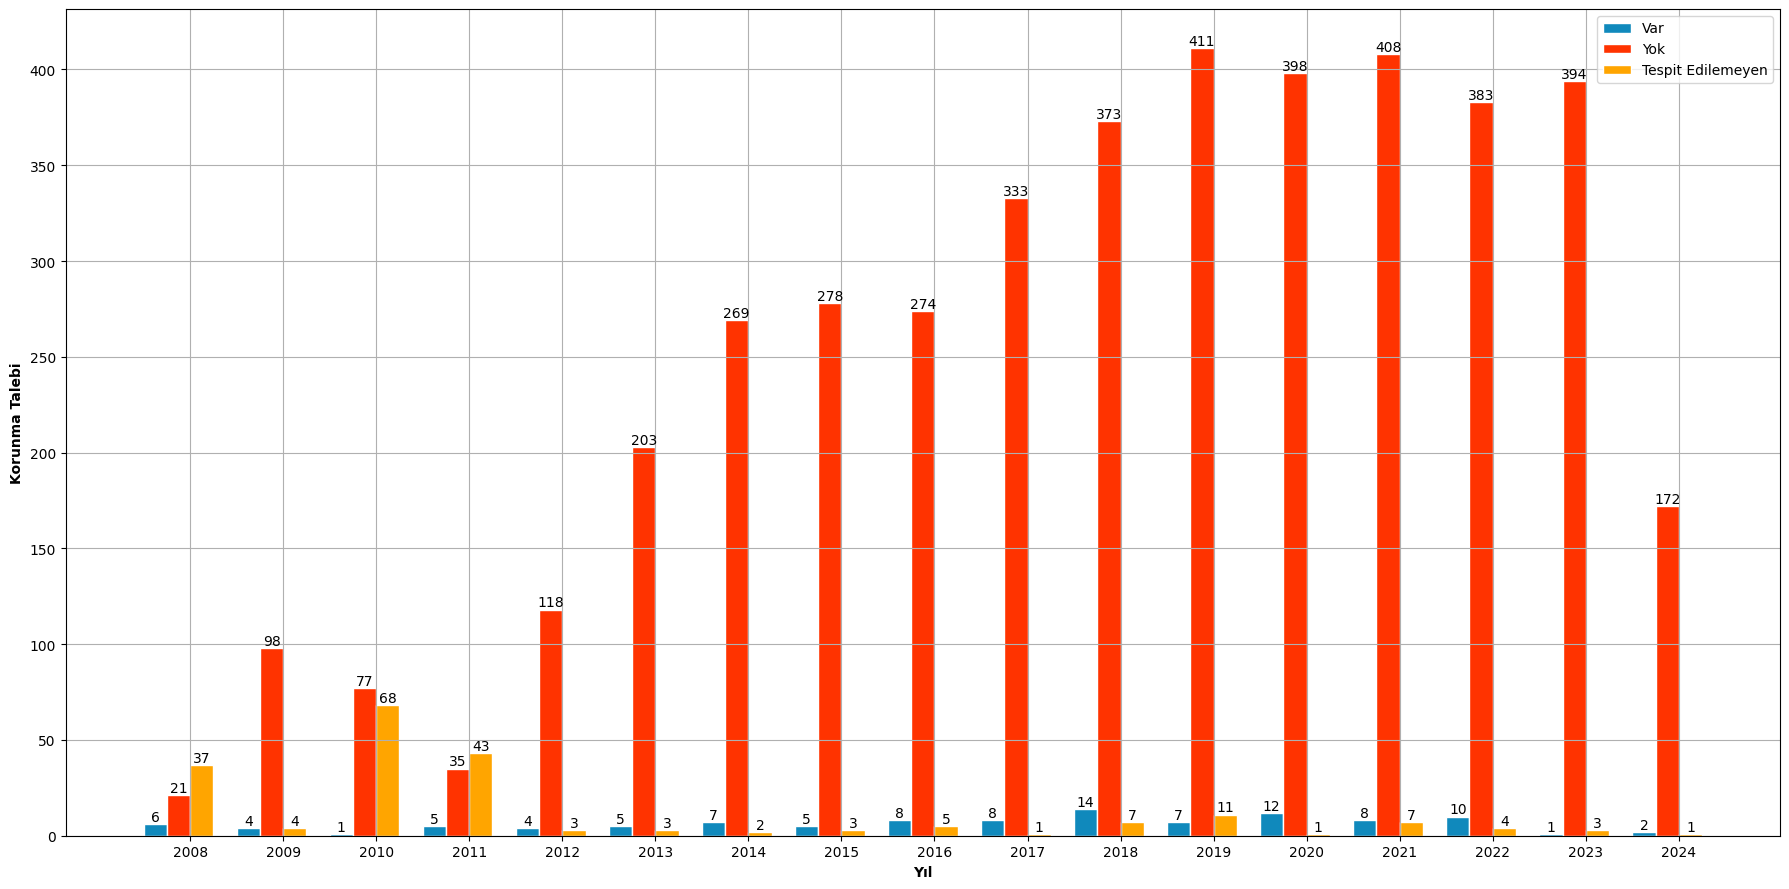

In [ ]:
# Seçilen dört başlığı belirleme
selected_statuses = ['Var', 'Yok', 'Tespit Edilemeyen']

# Seçilen başlıkları içeren veriyi filtreleme
filtered_data = df[df['korunma_talebi'].isin(selected_statuses)]

# Her fail durumu için yıllara göre öldürme vakalarının sayısını al
korunma_talebi_counts = []
for status in selected_statuses:
    korunma_talebi_counts.append(list(filtered_data[filtered_data['korunma_talebi'] == status]['yil'].value_counts().sort_index())),

# En yüksek sayıda eleman içeren liste uzunluğunu bulma
max_len = max(len(counts) for counts in korunma_talebi_counts)

# Her bir listeyi bu en yüksek sayıda eleman içerecek şekilde genişletme
for counts in korunma_talebi_counts:
    counts_length_diff = max_len - len(counts)
    counts.extend([0] * counts_length_diff)

# Bar genişliği ve pozisyonlarını ayarlama
barWidth = 0.25
r = np.arange(max_len)

# X eksenindeki yılları belirleme
years = range(2008, 2025)  # 2008'den 2024'e kadar (2025 dahil değil) olan yıllar
xticks_positions = np.arange(len(years))  # Yıl sayısı kadar konum belirleme

# Grafiği oluşturma
plt.figure(figsize=(18, 9))
plt.grid(zorder=0)

colors = ['#1089bc', '#ff3300', '#ffa500', 'purple', 'skyblue']

korunma_talebi_counts = []
for status in selected_statuses:
    korunma_talebi_counts.append(list(filtered_data[filtered_data['korunma_talebi'] == status]['yil'].value_counts().sort_index()))

for i, korunma_talebi_list in enumerate(korunma_talebi_counts):
    plt.bar(xticks_positions + barWidth * i, korunma_talebi_list, color=colors[i], width=barWidth, edgecolor='white', label=selected_statuses[i])

# Eksenleri ve başlığı ekleme
plt.xlabel('Yıl', fontweight='bold')
plt.ylabel('Korunma Talebi', fontweight='bold')
plt.xticks(xticks_positions + barWidth * len(selected_statuses) / 2, years)  # X ekseni etiketlerini ve konumlarını ayarlama

# Grafikteki değerleri gösterme
for i, korunma_talebi_list in enumerate(korunma_talebi_counts):
    for j, v in enumerate(korunma_talebi_list):
        plt.text(j + barWidth * i, v + 0.1, str(v), ha='center', va='bottom')

# Legend'ı ekleme
plt.legend()

# Grafiği gösterme
plt.tight_layout()
plt.show()

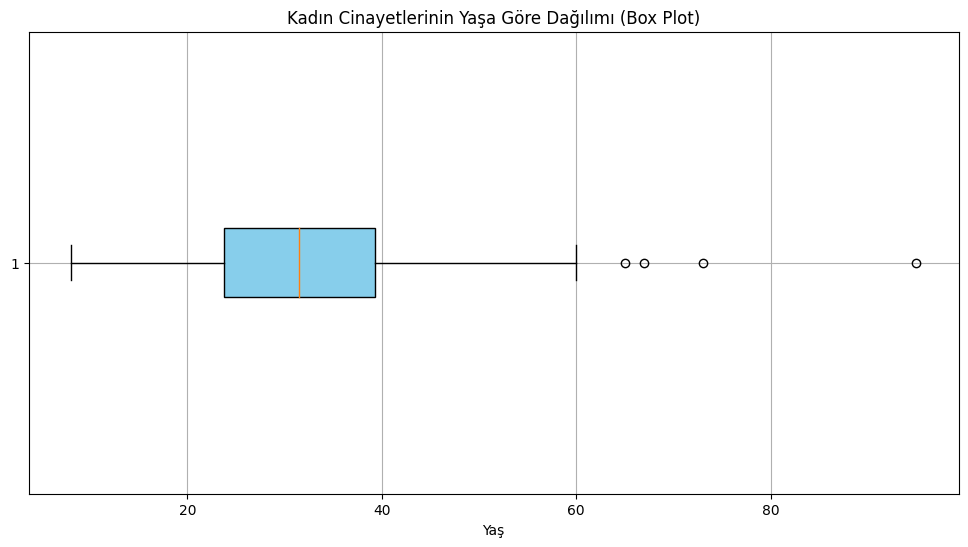

In [ ]:
# Yaş verilerini temizleme ve sayısal verilere çevirme
df['maktulun_yasi'] = pd.to_numeric(df['maktulun_yasi'], errors='coerce')
df_clean = df.dropna(subset=['maktulun_yasi'])

# Veriyi görselleştirme
plt.figure(figsize=(12, 6))
plt.boxplot(df_clean['maktulun_yasi'], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.xlabel('Yaş')
plt.title('Kadın Cinayetlerinin Yaşa Göre Dağılımı (Box Plot)')
plt.grid(True)
plt.show()

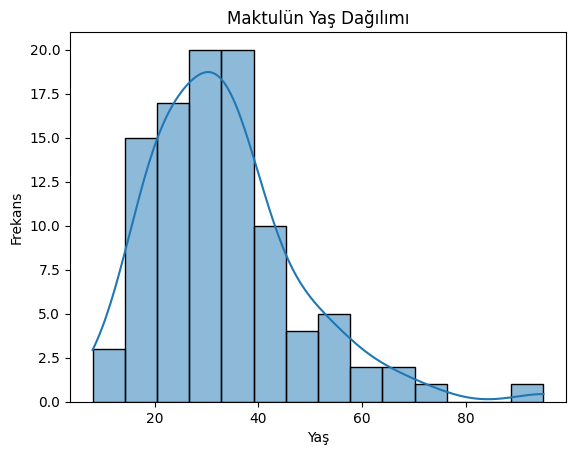

In [ ]:
# Yaş dağılımını görselleştirme
sns.histplot(df['maktulun_yasi'], kde=True)
plt.xlabel('Yaş')
plt.ylabel('Frekans')
plt.title('Maktulün Yaş Dağılımı')
plt.show()

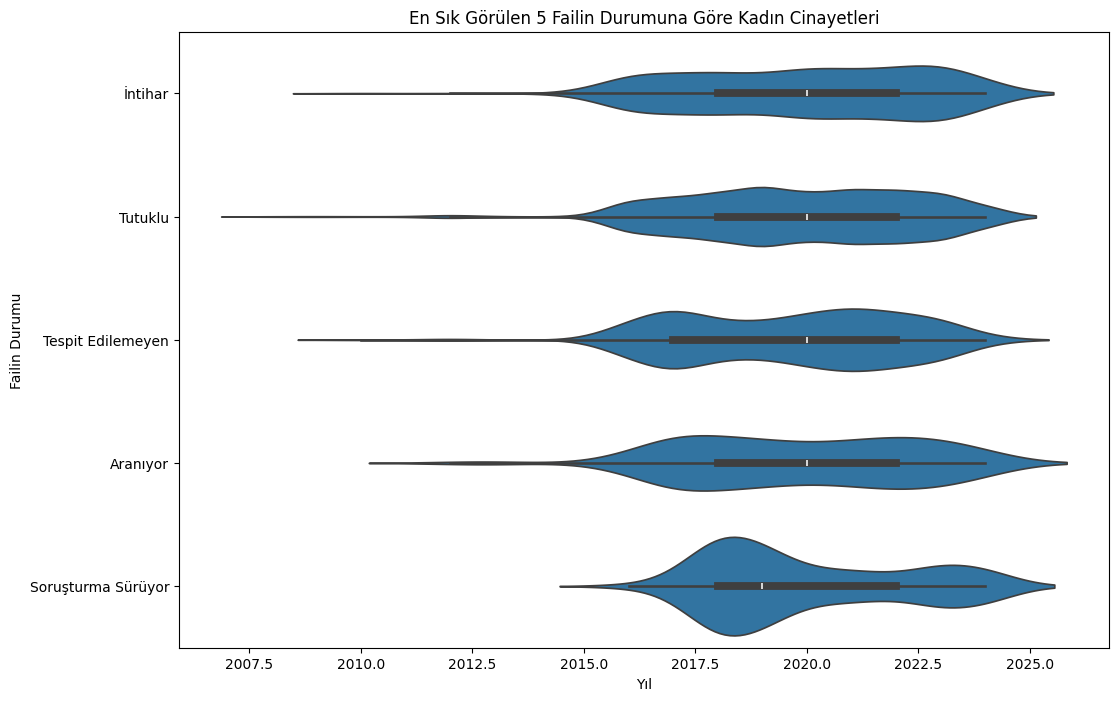

In [ ]:
# En sık görülen 5 failin durumu başlığını belirleyin
top_5_failin_durumu = df['failin_durumu'].value_counts().head(5).index

# Bu başlıklarla ilgili verileri filtreleyin
filtered_df = df[df['failin_durumu'].isin(top_5_failin_durumu)]

# Violin plot oluşturma
plt.figure(figsize=(12, 8))
sns.violinplot(x='yil', y='failin_durumu', data=filtered_df)
plt.title("En Sık Görülen 5 Failin Durumuna Göre Kadın Cinayetleri")
plt.xlabel("Yıl")
plt.ylabel("Failin Durumu")
plt.show()

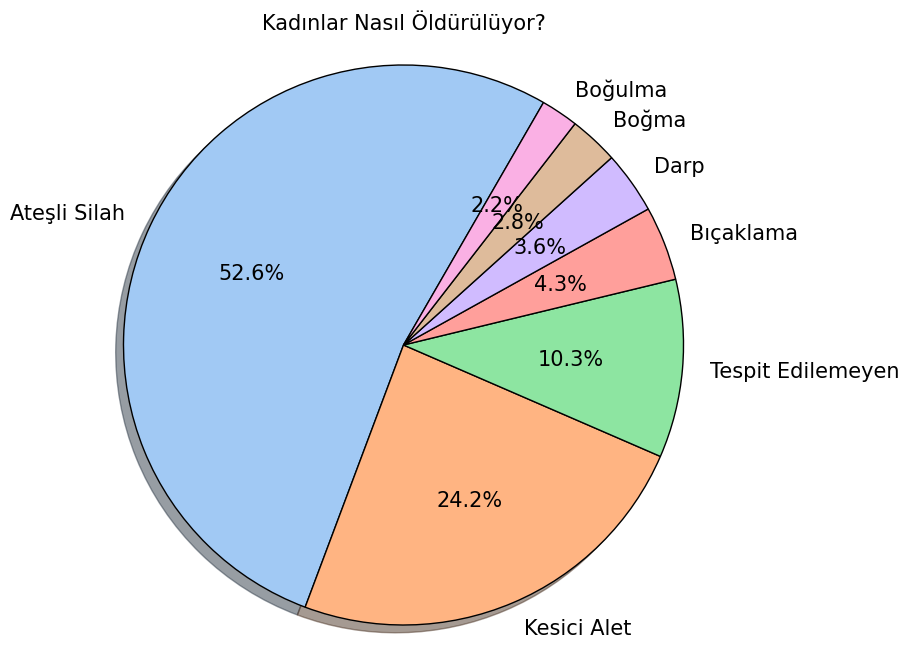

In [ ]:
# En sık görülen 7 öldürülme şeklini belirleyin
nasıl_olduruldu = df['oldurulme_sekli'].value_counts().head(7)

# Renk paleti oluşturma
colors = sns.color_palette('pastel')[0:7]

# Pie chart oluşturma
plt.figure(figsize=(9, 8))
nasıl_olduruldu.plot(kind='pie', startangle=60, shadow=True,fontsize=15, autopct="%1.1f%%", colors=colors, wedgeprops={'edgecolor': 'black'})

# Başlık ve etiket ayarları
plt.title("Kadınlar Nasıl Öldürülüyor?", fontsize=15)
plt.ylabel("", fontsize=15)
plt.axis('equal')  # Daire şeklinde yapar

# Gösterme
plt.show()

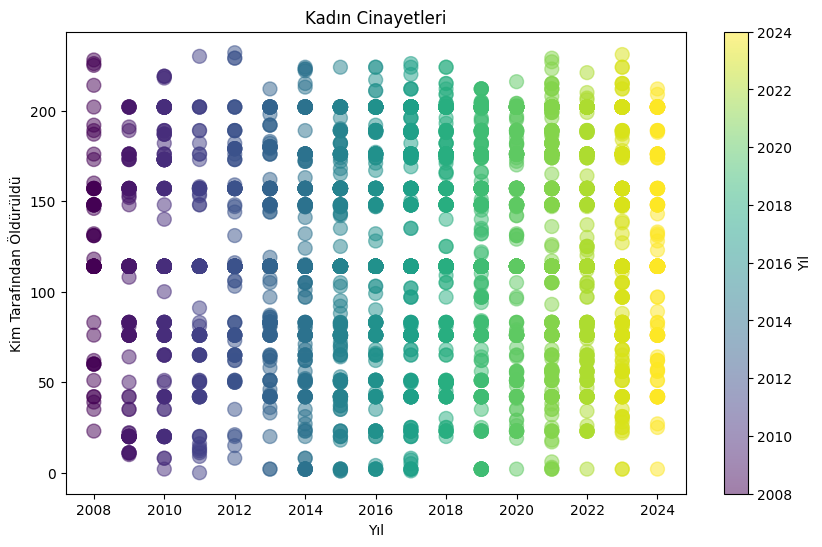

In [ ]:
# Eksik değerleri temizle (isteğe bağlı)
df_cleaned = df.dropna(subset=['kim_tarafindan_olduruldu', 'yil'])

# 'kim_tarafindan_olduruldu' sütununu uygun formatta dönüştür
# Örneğin, kategorik verilere sayısal değerler atayabiliriz
df_cleaned.loc[:, 'kim_tarafindan_olduruldu'] = df_cleaned['kim_tarafindan_olduruldu'].astype('category').cat.codes

# Yılları filtrele (2008'den 2024'e kadar)
df_filtered = df_cleaned[(df_cleaned['yil'] >= 2008) & (df_cleaned['yil'] <= 2024)]

# Sabit bir boyut belirle (tüm bubble'lar aynı boyutta olacak)
bubble_size = 100

# Bubble'ların rengini belirleyen sütunu uygun formatta dönüştür (isteğe bağlı)
# Örneğin, yıl bilgisine göre renklendirilebilir
colors = df_filtered['yil']

# Bubble chart'u oluştur
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['yil'], df_filtered['kim_tarafindan_olduruldu'], s=bubble_size, c=colors, alpha=0.5, cmap='viridis')
plt.xlabel('Yıl')
plt.ylabel('Kim Tarafından Öldürüldü')
plt.title('Kadın Cinayetleri')
plt.colorbar(label='Yıl')
plt.show()

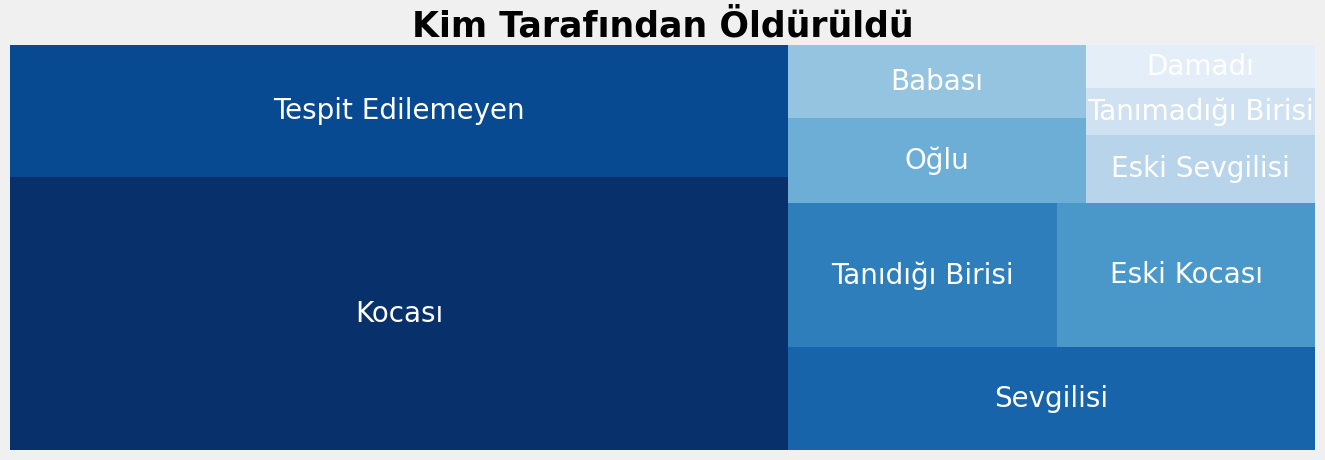

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import squarify

# Örnek veri oluşturun (df yerine kendi veri çerçevenizi kullanın)
y = df['kim_tarafindan_olduruldu'].value_counts().head(10)

plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('fivethirtyeight')

# Renk haritasını ters çevirme
color_map = plt.cm.Blues_r

# Yazı rengini ve boyutunu belirleme
text_kwargs = {'color': 'white', 'fontsize': 20}

# Treemap çizimi
squarify.plot(sizes=y.values, label=y.index, color=color_map(np.arange(len(y)) / len(y)), text_kwargs=text_kwargs)
plt.title('Kim Tarafından Öldürüldü', fontsize=25, fontweight='bold')
plt.axis('off')
plt.show()

In [ ]:
df['il_ilce'].value_counts()

il_ilce
İstanbul    546
İzmir       224
Antalya     169
Ankara      155
Adana       141
           ... 
Maltepe       1
Çiğli         1
Aralık        1
Saruhan       1
nevşehir      1
Name: count, Length: 163, dtype: int64

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/cihadturhan/tr-geojson/master/geo/tr-cities-utf8.json') as response:
    cities = json.load(response)
cities["features"][0]

{'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[35.279026031494084, 36.64069366455101],
     [35.28180694580078, 36.6390266418457],
     [35.282917022705135, 36.636806488037166],
     [35.27819442749029, 36.640140533447266],
     [35.279026031494084, 36.64069366455101]]],
   [[[35.27152633666998, 36.64485931396507],
     [35.274028778076456, 36.64319610595709],
     [35.274028778076456, 36.64208221435558],
     [35.27125167846697, 36.64319610595709],
     [35.27152633666998, 36.64485931396507]]],
   [[[35.20735931396513, 36.65069580078119],
     [35.2093048095706, 36.64986038208025],
     [35.20958328247099, 36.64930725097685],
     [35.206249237060604, 36.649028778076456],
     [35.20735931396513, 36.65069580078119]]],
   [[[35.21180725097656, 36.65541839599638],
     [35.212081909179744, 36.65319442749046],
     [35.21152877807634, 36.6529159545899],
     [35.20958328247099, 36.65513992309582],
     [35.21180725097656, 36.65541839599638]]],
   [[[35.21347045898466, 36.6598

In [ ]:
# Veri kümesini yükleyin
df_grouped = df.groupby(['il_ilce']).size().reset_index(name='kadın_cinayeti_sayısı')

# GeoJSON dosyasını yükleyin
with open('tr-cities-utf8.json', 'r', encoding='utf-8') as f:
    cities = json.load(f)

# GeoJSON verisini güncelleme
for loc in cities['features']:
    loc['id'] = loc['properties']['name']

# Choropleth haritası oluşturma
fig = go.Figure(go.Choroplethmapbox(
                    geojson=cities,
                    locations=df_grouped['il_ilce'],
                    z=df_grouped['kadın_cinayeti_sayısı'],
                    colorscale='Reds',  # Renk skalasını değiştirme
                    colorbar_title='Kadın Cinayeti Sayısı'))

# Harita stilini ve yakınlaştırmayı ayarlama
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=5,
                  mapbox_center={"lat": 38.963745, "lon": 35.243322},
                  margin={"r":0,"t":0,"l":0,"b":0})

# Haritayı gösterme
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

# Veri setini yıllara göre sıralayın ve ilk 2000 kaydı alın
joint_data = df.sort_values(by='yil', ascending=False).head(2000)

# Her neden_olduruldu ve yıl için kadın cinayeti sayısını hesaplayın
df_grouped = joint_data.groupby(['yil', 'neden_olduruldu']).size().reset_index(name='kadın_cinayeti_sayısı')

# Sunburst grafiği oluşturma
fig = px.sunburst(
    df_grouped,
    path=['yil', 'neden_olduruldu'],  # Yıl ve neden_olduruldu bilgilerini kullanarak sunburst grafiği oluşturma
    values='kadın_cinayeti_sayısı',  # Değer sütunu olarak 'kadın_cinayeti_sayısı' kullanılıyor
    color='yil'   # Renk sütunu olarak 'yil' kullanılıyor
)

# Grafiği gösterme
fig.show()

In [ ]:
data=pd.read_csv('latin_amerika_kadın_cinayeti.csv')

In [ ]:
data.head()

,yillar,ülkeler,kadın_cinayeti_sayısı
0,2005,Costa Rica,27
1,2006,Costa Rica,15
2,2007,Costa Rica,21
3,2008,Costa Rica,33
4,2009,Costa Rica,39


In [ ]:
data['kadın_cinayeti_sayısı'] = data['kadın_cinayeti_sayısı'].astype('Int64')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   yillar                 236 non-null    int64 
 1   ülkeler                236 non-null    object
 2   kadın_cinayeti_sayısı  236 non-null    Int64 
dtypes: Int64(1), int64(1), object(1)
memory usage: 5.9+ KB


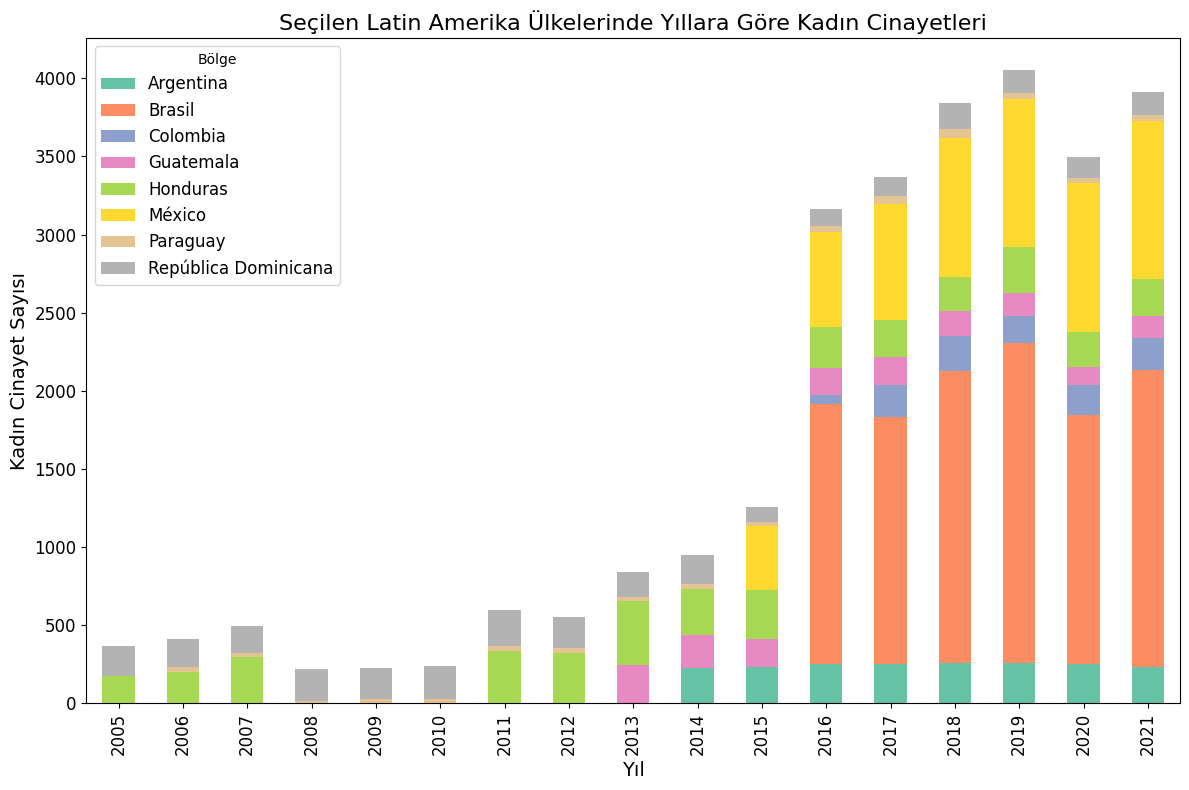

In [ ]:
# Latin Amerika veri seti üzerinde işlem yapalım
data['yillar'] = data['yillar'].astype(int)
latin_america_grouped = data.groupby(['yillar', 'ülkeler'])['kadın_cinayeti_sayısı'].sum().reset_index()

# Seçilen ülkeler için veri setini filtreleyelim (örnek olarak bazı ülkeler seçildi)
latin_america_countries = ['Paraguay','Guatemala','Honduras', 'Argentina', 'Colombia','México', 'Brasil','República Dominicana',]
latin_america_grouped = latin_america_grouped[latin_america_grouped['ülkeler'].isin(latin_america_countries)]

# Grafik için pivot tablo oluşturma

latin_america_pivot = latin_america_grouped.pivot(index='yillar', columns='ülkeler', values='kadın_cinayeti_sayısı').fillna(0)

# Grafik boyutları
plt.figure(figsize=(12, 8))

# Latin Amerika için yığılmış çubuk grafiği
latin_america_pivot.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set2')

# Grafik başlığı ve etiketler
plt.title('Seçilen Latin Amerika Ülkelerinde Yıllara Göre Kadın Cinayetleri', fontsize=16)
plt.xlabel('Yıl', fontsize=14)
plt.ylabel('Kadın Cinayet Sayısı', fontsize=14)
plt.legend(title='Bölge', fontsize=12)

# Eksenlerin değerleri ve font boyutları
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Grafiği gösterme
plt.tight_layout()
plt.show()

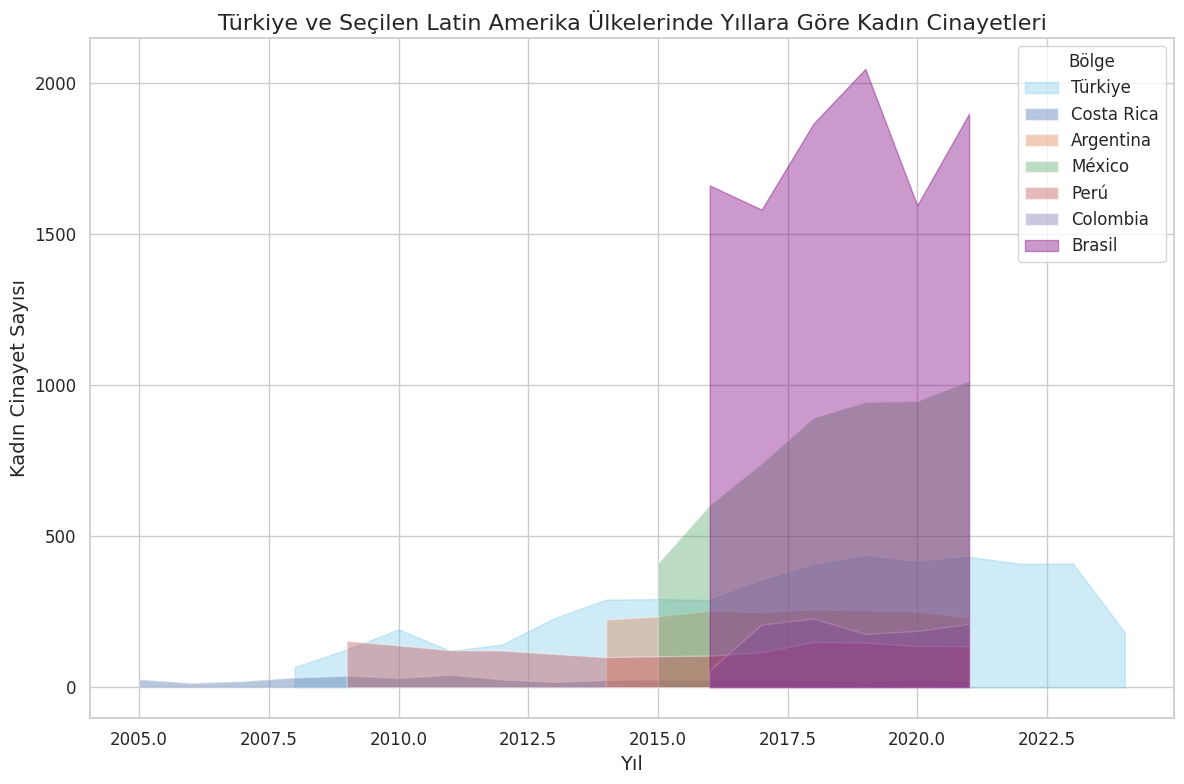

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Latin Amerika kadın cinayetleri veri seti
latin_america_data = pd.read_csv('latin_amerika_kadın_cinayeti.csv')

# Türkiye kadın cinayetleri veri seti
data = pd.read_csv('anitsayac_veriseti(2008-2024)_yil_eklendi.csv')

# Yılları tam sayıya dönüştürme
latin_america_data['yillar'] = latin_america_data['yillar'].astype(int)

# Türkiye veri seti üzerinde işlem yapalım
data_clean = data.dropna(subset=['yil'])
turkey_grouped = data_clean['yil'].value_counts().sort_index().reset_index()
turkey_grouped.columns = ['yil', 'kadın_cinayeti_sayısı']

# Latin Amerika veri seti üzerinde işlem yapalım
latin_america_data['yillar'] = latin_america_data['yillar'].astype(int)
latin_america_grouped = latin_america_data.groupby(['yillar', 'ülkeler'])['kadın_cinayeti_sayısı'].sum().reset_index()

# Seçilen ülkeler için veri setini filtreleyelim (örnek olarak bazı ülkeler seçildi)
latin_america_countries = ['Costa Rica', 'Argentina', 'México' ,'Perú', 'Colombia', 'Brasil']
latin_america_grouped = latin_america_grouped[latin_america_grouped['ülkeler'].isin(latin_america_countries)]

# Seaborn stili
sns.set(style="whitegrid")

# Grafik boyutları
plt.figure(figsize=(12, 8))

# Türkiye için alan grafiği
plt.fill_between(turkey_grouped['yil'], turkey_grouped['kadın_cinayeti_sayısı'], color='skyblue', alpha=0.4, label='Türkiye')

# Latin Amerika için alan grafiği (seçilen ülkeler için)
for country in latin_america_countries:
    if country == 'Brasil':
        plt.fill_between(latin_america_grouped[latin_america_grouped['ülkeler'] == country]['yillar'],
                         latin_america_grouped[latin_america_grouped['ülkeler'] == country]['kadın_cinayeti_sayısı'],
                         color='purple', alpha=0.4, label=country)
    else:
        country_data = latin_america_grouped[latin_america_grouped['ülkeler'] == country]
        plt.fill_between(country_data['yillar'], country_data['kadın_cinayeti_sayısı'], alpha=0.4, label=country)

# Grafik başlığı ve etiketler
plt.title('Türkiye ve Seçilen Latin Amerika Ülkelerinde Yıllara Göre Kadın Cinayetleri', fontsize=16)
plt.xlabel('Yıl', fontsize=14)
plt.ylabel('Kadın Cinayet Sayısı', fontsize=14)
plt.legend(title='Bölge', fontsize=12)

# Eksenlerin değerleri ve font boyutları
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Grafiği gösterme
plt.tight_layout()
plt.show()

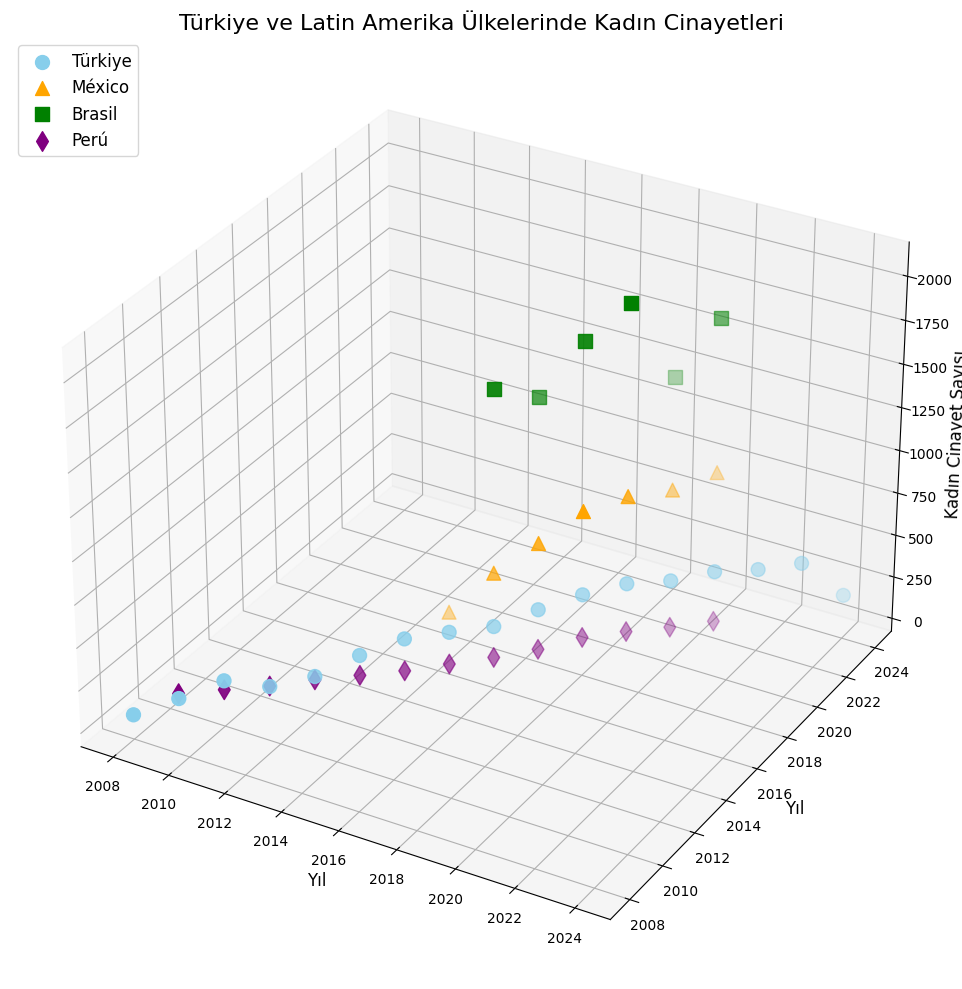

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Türkiye veri seti
turkey_data = pd.read_csv('anitsayac_veriseti(2008-2024)_yil_eklendi.csv')

# Latin Amerika veri seti (El Salvador, Guatemala, Argentina)
latin_america_data = pd.read_csv('latin_amerika_kadın_cinayeti.csv')

# Türkiye veri setinde yılları tam sayıya dönüştürme ve gereksiz sütunları düşürme
turkey_clean = turkey_data.dropna(subset=['yil'])
turkey_grouped = turkey_clean['yil'].value_counts().sort_index().reset_index()
turkey_grouped.columns = ['yil', 'turkiye_kadın_cinayeti_sayısı']

# Latin Amerika ülkeleri için veri setinde ilgili ülkeleri filtreleyelim
countries = ['México', 'Brasil','Perú']
latin_america_filtered = latin_america_data[latin_america_data['ülkeler'].isin(countries)]

# Ülkeler için yıllara göre gruplama ve kadın cinayeti sayılarını alma
country_groups = {}
for country in countries:
    country_data = latin_america_filtered[latin_america_filtered['ülkeler'] == country]
    country_clean = country_data.dropna(subset=['yillar'])
    country_grouped = country_clean.groupby('yillar')['kadın_cinayeti_sayısı'].sum().reset_index()
    country_groups[country] = country_grouped

# Verileri uygun formatta alalım
x_turkey = turkey_grouped['yil']
y_turkey = turkey_grouped['yil']
z_turkey = turkey_grouped['turkiye_kadın_cinayeti_sayısı']

# Grafik boyutları ve stili
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Türkiye için scatter plot
ax.scatter(x_turkey, y_turkey, z_turkey, c='skyblue', marker='o', s=100, label='Türkiye')

# Latin Amerika ülkeleri için scatter plot
colors = ['orange', 'green', 'purple']
markers = ['^', 's', 'd']
for i, country in enumerate(countries):
    x_country = country_groups[country]['yillar']
    y_country = country_groups[country]['yillar']
    z_country = country_groups[country]['kadın_cinayeti_sayısı']
    ax.scatter(x_country, y_country, z_country, c=colors[i], marker=markers[i], s=100, label=country)

# Eksen etiketleri
ax.set_xlabel('Yıl', fontsize=12)
ax.set_ylabel('Yıl', fontsize=12)
ax.set_zlabel('Kadın Cinayet Sayısı', fontsize=12)

# Grafik başlığı ve legend
plt.title('Türkiye ve Latin Amerika Ülkelerinde Kadın Cinayetleri', fontsize=16)
plt.legend(loc='upper left', fontsize=12)


plt.tight_layout()
plt.show()

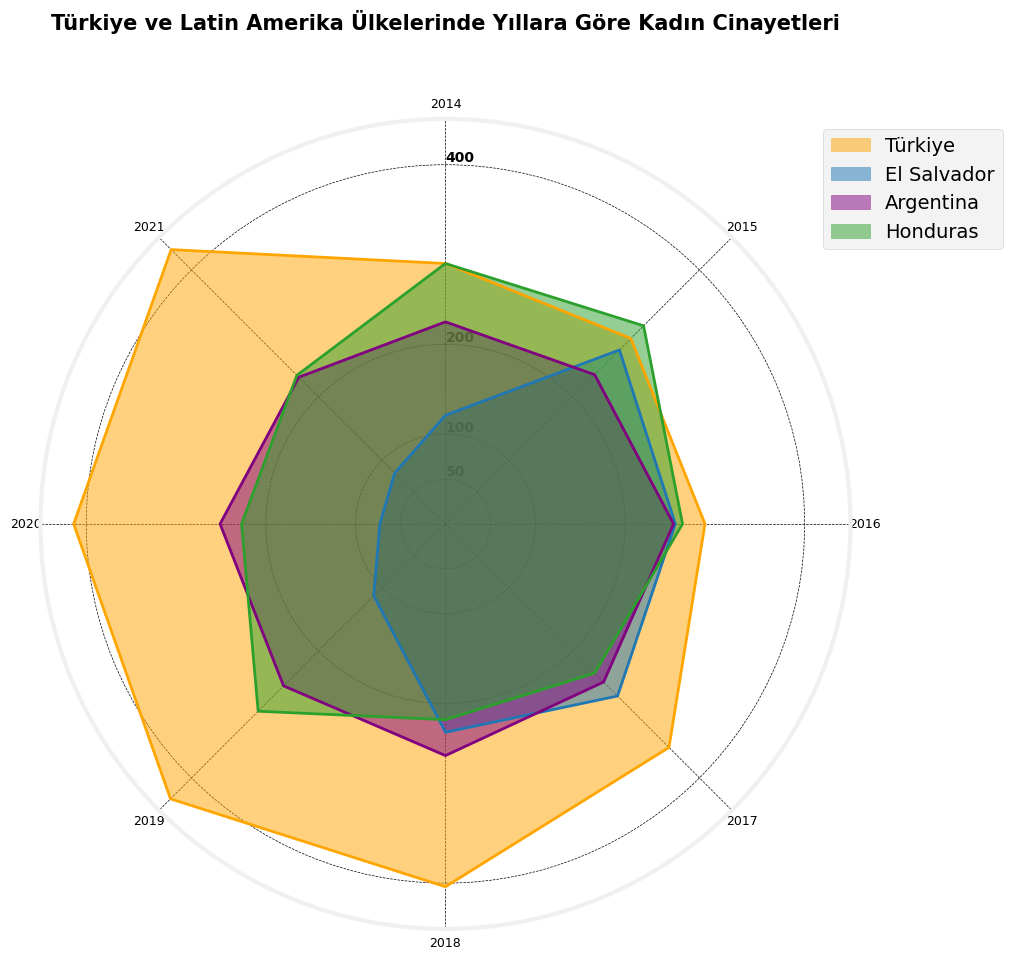

In [ ]:
# Türkiye veri seti
turkey_data = pd.read_csv('anitsayac_veriseti(2008-2024)_yil_eklendi.csv')

# Latin Amerika veri seti (El Salvador, Guatemala, Argentina)
latin_america_data = pd.read_csv('latin_amerika_kadın_cinayeti.csv')

# Türkiye veri setinde yılları tam sayıya dönüştürme ve gereksiz sütunları düşürme
turkey_clean = turkey_data.dropna(subset=['yil'])
turkey_grouped = turkey_clean['yil'].value_counts().sort_index().reset_index()
turkey_grouped.columns = ['yil', 'turkiye_kadın_cinayeti_sayısı']

# Latin Amerika ülkeleri için veri setinde ilgili ülkeleri filtreleyelim
countries = ['El Salvador', 'Argentina', 'Honduras']
latin_america_filtered = latin_america_data[latin_america_data['ülkeler'].isin(countries)]

# Her ülke için kadın cinayet sayılarını yıllara göre gruplama ve sütun adlarını değiştirme
country_groups = {}
for country in countries:
    country_data = latin_america_filtered[latin_america_filtered['ülkeler'] == country]
    country_grouped = country_data.dropna(subset=['yillar'])
    country_grouped = country_grouped.groupby('yillar')['kadın_cinayeti_sayısı'].sum().reset_index()
    country_grouped.columns = ['yil', f'{country}_kadın_cinayeti_sayısı']
    country_groups[country] = country_grouped

# Ortak yılları belirleme ve veri setlerini ortak yıllara göre hizalama
common_years = set(turkey_grouped['yil'])
for country in countries:
    common_years &= set(country_groups[country]['yil'])

common_years = sorted(common_years)
turkey_grouped = turkey_grouped[turkey_grouped['yil'].isin(common_years)]
for country in countries:
    country_groups[country] = country_groups[country][country_groups[country]['yil'].isin(common_years)]

# Değerlerin listesini alma ve yıllara göre sıralama
turkey_values = turkey_grouped.sort_values('yil')['turkiye_kadın_cinayeti_sayısı'].tolist()
country_values = {country: country_groups[country].sort_values('yil')[f'{country}_kadın_cinayeti_sayısı'].tolist() for country in countries}

# Spider (Radar) Grafik için açıların hesaplanması
angles = np.linspace(0, 2 * np.pi, len(common_years), endpoint=False).tolist()
angles += angles[:1]  # İlk açıyı sona ekleme işlemi

# Değerlerin de ilk elemanlarını sona ekleme işlemi (çemberi kapatmak için)
turkey_values += turkey_values[:1]
for country in countries:
    country_values[country] += country_values[country][:1]

# Grafik boyutları ve stil
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('white')  # Figür arka planını beyaz yapma

# Türkiye için spider grafik çizimi
ax.fill(angles, turkey_values, color='orange', alpha=0.5, label='Türkiye')
ax.plot(angles, turkey_values, color='orange', linewidth=2)

# Latin Amerika ülkeleri için spider grafik çizimi
colors = ['#1f77b4', 'purple', '#2ca02c']  # Farklı ve hoş renkler
for i, country in enumerate(countries):
    ax.fill(angles, country_values[country], color=colors[i], alpha=0.5, label=country)
    ax.plot(angles, country_values[country], color=colors[i], linewidth=2)

# Eksen etiketleri ve stil ayarları
ax.set_theta_offset(np.pi / 2)  # Açısal offset
ax.set_theta_direction(-1)  # Saat yönü
plt.xticks(angles[:-1], common_years, color='black', size=9)  # Eksen etiketleri
ax.set_rlabel_position(0)  # Y ekseni etiketlerinin pozisyonu
plt.yticks([50, 100, 200, 400], ['50', '100', '200', '400'], color="black", size=10, fontweight='bold')
ax.grid(True, color='black', linestyle='--', linewidth=0.5)  # Izgara çizgileri

# Grafik başlığı ve legend
plt.title('Türkiye ve Latin Amerika Ülkelerinde Yıllara Göre Kadın Cinayetleri', size=15, y=1.1, color='black', fontweight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))  # Legend konumu

# Arka plan rengi
ax.set_facecolor('white')

# Grafik gösterme
plt.show()

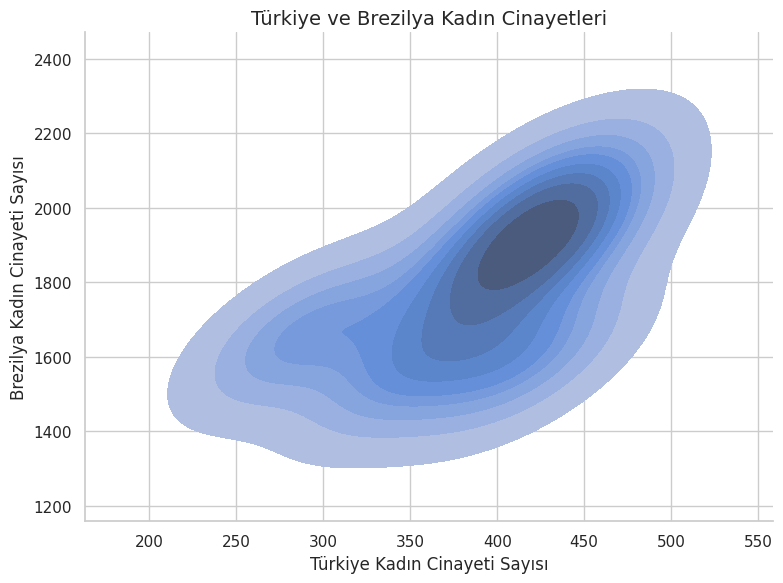

In [ ]:
# Türkiye veri seti
turkey_data = pd.read_csv('anitsayac_veriseti(2008-2024)_yil_eklendi.csv')

# Latin Amerika veri seti
latin_america_data = pd.read_csv('latin_amerika_kadın_cinayeti.csv')

# Türkiye veri setinde yılları tam sayıya dönüştürme ve gereksiz sütunları düşürme
turkey_clean = turkey_data.dropna(subset=['yil'])
turkey_grouped = turkey_clean['yil'].value_counts().sort_index().reset_index()
turkey_grouped.columns = ['yil', 'turkiye_kadın_cinayeti_sayısı']

# Brezilya için kadın cinayet sayılarını yıllara göre gruplama ve sütun adlarını değiştirme
latin_america_filtered = latin_america_data[latin_america_data['ülkeler'] == 'Brasil']  # Brezilya için filtreleme
latin_america_clean = latin_america_filtered.dropna(subset=['yillar'])
latin_america_grouped = latin_america_clean.groupby('yillar')['kadın_cinayeti_sayısı'].sum().reset_index()
latin_america_grouped.columns = ['yil', 'brazil_kadın_cinayeti_sayısı']  # Sütun adlarını güncelle

# Verileri ortak yıllara göre hizalama
common_years = set(turkey_grouped['yil']).intersection(set(latin_america_grouped['yil']))
turkey_grouped = turkey_grouped[turkey_grouped['yil'].isin(common_years)]
latin_america_grouped = latin_america_grouped[latin_america_grouped['yil'].isin(common_years)]

# Türkiye ve Brezilya verilerini birleştirme
merged_data = pd.merge(turkey_grouped, latin_america_grouped, on='yil')

# KDE Plot grafiği oluşturma
plt.figure(figsize=(8, 6))
sns.kdeplot(data=merged_data.sort_values('turkiye_kadın_cinayeti_sayısı'), x='turkiye_kadın_cinayeti_sayısı', y='brazil_kadın_cinayeti_sayısı', fill=True)
plt.xlabel('Türkiye Kadın Cinayeti Sayısı', fontsize=12)
plt.ylabel('Brezilya Kadın Cinayeti Sayısı', fontsize=12)
plt.title('Türkiye ve Brezilya Kadın Cinayetleri', fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()